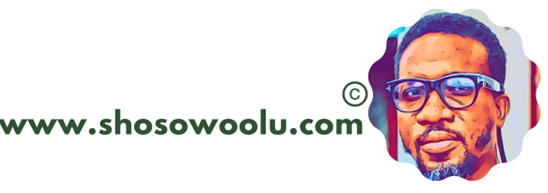

# Prediction of Success of Start-Ups Using Unbiased Classification Models

# Notebook 2: Data Transformation

**Purpose:** This notebook would be used to carry out the final data set transaformation and preparation for modelling experiments. This will entail ensuring the dataset outputted from the EDA and cleaning stage is infact clean and also carrying out some feature engineering to further improve the dataset. At this stage the data will be slight into the training , validation and test datasets.

The text, categorical and numerical columns transformation would be carried out as this stage.

**Data**
Historical data about companies was sourced from Crunchbase. Crunchbase tracks and collects information about millions of companies and related personnel. Past research works has been carried out using Crunchbase data but features such as company descriptions and people descriptions and other textual features. 

Attempt to further enrich the dataset information from scraped social media is currently onhold even though the Twitter code and related Sensitivity Analysis code is in place. This is due to the current Twitter restriction requiring account log in for each attempt to scrape thus, making this unachievable for the 2m+ rows of data.


In [1]:
# !pip install pandas_profiling
# !pip install  ydata_profiling

#!pip install plotly

In [1]:
# Import Data Cleaning and Wrangling Libraries
import pandas as pd
import numpy as np
from datetime import date
import os
import warnings
import dill


# # Import Visualisation Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px



# Import other needed achine Learning Libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score


ImportError: cannot import name '_c_internal_utils' from partially initialized module 'matplotlib' (most likely due to a circular import) (d:\OneDrive\Documents\Personal Project Portfolio\PP00017_Prediction of the Success of Start-Ups\venv\Lib\site-packages\matplotlib\__init__.py)

In [2]:
#import the cleaned backbone dataset 
df = pd.read_csv(
    'D:\\OneDrive\\Documents\\PERSONAL\\PERSONAL DEVELOPMENT\\DATA SCIENCE\\'
    'Personal Project Portfolio\\PP00017_Prediction of the Success of Start-Ups Using Unbiased Classification ML Models'
    '\\artifacts\\data_cleaning\\unclean_backbone.csv', 
    parse_dates=['founded_on','last_funding_on','closed_on','degree_started_on','degree_completed_on'])

# View all the rows and columns and rows
pd.set_option('display.max_columns', len(df.columns))
pd.set_option('display.max_rows', len(df))

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\OneDrive\\Documents\\PERSONAL\\PERSONAL DEVELOPMENT\\DATA SCIENCE\\Personal Project Portfolio\\PP00017_Prediction of the Success of Start-Ups Using Unbiased Classification ML Models\\artifacts\\data_cleaning\\unclean_backbone.csv'

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   uuid                            177 non-null    object        
 1   name                            177 non-null    object        
 2   type                            177 non-null    object        
 3   rank                            177 non-null    int64         
 4   roles                           177 non-null    object        
 5   status                          177 non-null    object        
 6   category_list                   177 non-null    object        
 7   category_groups_list            177 non-null    object        
 8   total_funding_usd               177 non-null    float64       
 9   founded_on                      177 non-null    datetime64[ns]
 10  last_funding_on                 177 non-null    datetime64[ns]
 11  closed

**Next Steps**
* Clean and impute missing values in the final dataset
* Carry out the EDA analysis
* Carry out the feature engineering
* Carry out column transformation
* Save the final dataset for modelling and experiments

In [5]:
# Check for missing values
df.isna().sum()

uuid                                0
name                                0
type                                0
rank                                0
roles                               0
status                              0
category_list                       0
category_groups_list                0
total_funding_usd                   0
founded_on                          0
last_funding_on                     0
closed_on                           0
employee_count                      0
facebook_url                        0
linkedin_url                        0
twitter_url                         0
primary_role                        0
organization_description            0
person_uuid                         0
first_name                          0
last_name                           0
gender                              0
featured_job_organization_uuid      0
featured_job_organization_name      0
featured_job_title                  0
people_facebook_url                 0
people_linke

In [6]:
# The following features should be filled with 'not known' and 'False' respectively  
df['institution_name'].fillna('not known',inplace=True)
df['degree_type'].fillna('not known',inplace=True)
df['subject'].fillna('not known',inplace=True)
df['degree_is_completed'].fillna('False',inplace=True)

In [7]:
# The dates will be filled with current date so that the derived dates from these will be zero (0)
for col in df.columns:
    if df[col].dtype == 'O':
        df[col].fillna('not known',inplace=True)
    elif not df[col].dtype == '<M8[ns]':
        df[col].fillna(0,inplace=True)
    elif df[col].dtype == '<M8[ns]':
        df[col].fillna(np.datetime64(date.today()), inplace=True)

In [8]:
# Cast the data type for 'exhibitor', 'organizer', 'speaker', 'sponsor' from float to int
df['exhibitor'] = df['exhibitor'].astype(int)
df['organizer'] = df['organizer'].astype(int)
df['speaker'] = df['speaker'].astype(int)
df['sponsor'] = df['sponsor'].astype(int)

In [9]:
# drop all all rows with duplicate values across all columns.
df.drop_duplicates(keep='first', inplace=True)

**Feature Engineering**

We will derive features from the date based columns as follows:

* per_exp_at_coy_start  = founded_on - degree_completed_on (This the experience of the personnel at founding date of company)
* degree Length = degree_completed_on - degree_started_on
* yrs_since_last_funding = last_funding_on - date.today()
* yrs_of_operation = closed_on - founded_on or date.today() - founded_on

then, 

We will drop the following columns
* facebook_url
* twitter_url
* linkedin_url
* closed_on
* degree_completed_on
* degree_started_on
* founded_on
* people_facebook_url
* people_twitter_url
* people_linkedin_url
* firstname
* lastname
* org_uuid
* institution_uuid

Finally we will rearrange the features as Index -> Numerical -> Categorical -> Text -> Target/Label


* per_exp_at_coy_start = founded_on - degree_completed_on (This the experience of the personnel at founding date of company)
* degree Length = degree_completed_on - degree_started_on
* yrs_since_last_funding = last_funding_on - date.today()
* yrs_of_operation = closed_on - founded_on or date.today() - founded_on

In [10]:
# Create column for the years of experience of personnel at the founding of the company
df["per_exp_at_coy_start"] = (df.founded_on - df.degree_completed_on)

# Convert the negative values to 0 days
df["per_exp_at_coy_start"] = df["per_exp_at_coy_start"].apply(
    lambda x: x if(x/pd.Timedelta(hours=1) > 0) else (pd.Timedelta(seconds=0)) )

# Covert the days to years 
df["per_exp_at_coy_start"] = ((df["per_exp_at_coy_start"].dt.days)/365).astype(int)

In [11]:
# Create a column for the Length of degree of personnel
df["degree_length"] = (df.degree_completed_on - df.degree_started_on)

# Convert the negative values to 0 days
df["degree_length"] = df["degree_length"].apply(
    lambda x: x if(x/pd.Timedelta(hours=1) > 0) else (pd.Timedelta(seconds=0)) )

# Covert the days to years 
df["degree_length"] = ((df["degree_length"].dt.days)/365).astype(int)

In [12]:
# Create a column for the years since the last funding received by the organisation
df['yrs_since_last_funding'] = np.datetime64(date.today()) - df['last_funding_on']

# Convert the negative values to 0 days
df['yrs_since_last_funding'] = df['yrs_since_last_funding'].apply(
    lambda x: x if(x/pd.Timedelta(hours=1) > 0) else (pd.Timedelta(seconds=0)) )

# Covert the days to years 
df['yrs_since_last_funding'] = ((df['yrs_since_last_funding'].dt.days)/365).astype(int)

In [13]:
# Create a column for the years of operation of the organisation
df['yrs_of_operation'] = df['closed_on'] - df['founded_on'] 

# Convert the negative values to 0 days
df['yrs_of_operation'] = df['yrs_of_operation'].apply(
    lambda x: x if(x/pd.Timedelta(hours=1) > 0) else (pd.Timedelta(seconds=0)) )

# Covert the days to years 
df['yrs_of_operation'] = ((df['yrs_of_operation'].dt.days)/365).astype(int)

In [14]:
df

,uuid,name,type,rank,roles,status,category_list,category_groups_list,total_funding_usd,founded_on,last_funding_on,closed_on,employee_count,facebook_url,linkedin_url,twitter_url,primary_role,organization_description,person_uuid,first_name,last_name,...,people_facebook_url,people_linkedin_url,people_twitter_url,people_description,institution_uuid,institution_name,degree_type,subject,degree_started_on,degree_completed_on,degree_is_completed,exhibitor,organizer,speaker,sponsor,org_uuid,success,per_exp_at_coy_start,degree_length,yrs_since_last_funding,yrs_of_operation
0,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,13275,"investor,company",operating,"Cloud Computing,Collaboration,Developer Tools,...","Administrative Services,Apps,Information Techn...",0.000000e+00,1996-03-17,2024-02-11,2024-02-11,10000,http://www.facebook.com/zoho,https://www.linkedin.com/company/zoho,http://twitter.com/zoho,company,"Zoho offers a suite of business, collaboration...",9f99a98a-aa97-b30b-0d36-db67c1d277e0,Raju,Vegesna,...,not known,https://www.linkedin.com/in/raju-vegesna-78a6541,https://twitter.com/rajuv,Raju is an evangelist for Zoho and is one of t...,not known,not known,not known,not known,2024-02-24,2024-02-24,False,0,0,0,0,not known,0,0,0,0,27
1,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,13275,"investor,company",operating,"Cloud Computing,Collaboration,Developer Tools,...","Administrative Services,Apps,Information Techn...",0.000000e+00,1996-03-17,2024-02-11,2024-02-11,10000,http://www.facebook.com/zoho,https://www.linkedin.com/company/zoho,http://twitter.com/zoho,company,"Zoho offers a suite of business, collaboration...",6e1bca72-a865-b518-b305-31214ce2d1b0,Ian,Wenig,...,not known,not known,not known,Ian Wenig has more then twenty years experienc...,not known,not known,not known,not known,2024-02-24,2024-02-24,False,0,0,0,0,not known,0,0,0,0,27
2,f4d5ab44-058b-298b-ea81-380e6e9a8eec,Omidyar Network,organization,18929,"investor,company",operating,"Enterprise Software,Financial Services,Venture...","Financial Services,Lending and Investments,Sof...",0.000000e+00,2004-01-01,2024-02-11,2024-02-11,101,http://www.facebook.com/OmidyarNetwork,http://www.linkedin.com/company/22806,http://twitter.com/OmidyarNetwork,investor,"Pierre Omidyar, the founder of eBay, and his w...",d541c41a-1524-14d7-3926-0d0ac5c0aee3,Pierre,Omidyar,...,not known,https://www.linkedin.com/in/pierre-omidyar-bb1...,https://twitter.com/pierre,"Pierre Omidyar is the Founding Partner, Co-Fou...",not known,not known,not known,not known,2024-02-24,2024-02-24,False,0,0,0,0,not known,0,0,0,0,20
3,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,5,"investor,company",ipo,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",2.462282e+10,2004-02-04,2022-08-04,2024-02-11,10000,https://www.facebook.com/Meta,https://www.linkedin.com/company/meta,https://www.twitter.com/Meta,company,Meta is a social technology company that enabl...,a01b8d46-d311-3333-7c34-aa3ae9c03f22,Mark,Zuckerberg,...,https://www.facebook.com/zuck,https://www.linkedin.com/in/mark-zuckerberg-61...,https://www.twitter.com/finkd,"Mark Zuckerberg is the Founder, Chairman, and ...",not known,not known,not known,not known,2024-02-24,2024-02-24,False,2,0,0,1,df662812-7f97-0b43-9d3e-12f64f504fbb,1,0,0,1,20
5,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,5,"investor,company",ipo,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",2.462282e+10,2004-02-04,2022-08-04,2024-02-11,10000,https://www.facebook.com/Meta,https://www.linkedin.com/company/meta,https://www.twitter.com/Meta,company,Meta is a social technology company that enabl...,794063fa-8cd5-2ee7-0987-3eaaa37c73db,Jason,Rubin,...,http://www.facebook.com/thejasonrubin,http://www.linkedin.com/in/jasonrubin,http://twitter.com/jason_rubin,Jason Rubin is the VP Metaverse Content at Met...,not known,not known,not known,not known,2024-02-24,2024-02

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158 entries, 0 to 176
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   uuid                            158 non-null    object        
 1   name                            158 non-null    object        
 2   type                            158 non-null    object        
 3   rank                            158 non-null    int64         
 4   roles                           158 non-null    object        
 5   status                          158 non-null    object        
 6   category_list                   158 non-null    object        
 7   category_groups_list            158 non-null    object        
 8   total_funding_usd               158 non-null    float64       
 9   founded_on                      158 non-null    datetime64[ns]
 10  last_funding_on                 158 non-null    datetime64[ns]
 11  closed_on  

In [16]:
# Drop the columns that are no longer required
df.drop(['founded_on','closed_on','facebook_url','linkedin_url','twitter_url','person_uuid',
               'founded_on','last_funding_on', 'first_name','last_name', 'featured_job_organization_uuid', 'featured_job_organization_name',
               'people_facebook_url', 'people_linkedin_url', 'people_twitter_url', 'institution_uuid',
               'degree_started_on', 'degree_completed_on', 'org_uuid'],axis=1,inplace=True)

In [17]:
# rearrange the dataset features
df = df[['yrs_of_operation', 'yrs_since_last_funding', 'degree_length', 'per_exp_at_coy_start','sponsor','speaker',
    'organizer','exhibitor', 'employee_count', 'total_funding_usd','rank','uuid',
    'name', 'type', 'roles', 'status', 'category_list', 'category_groups_list', 'primary_role',
       'organization_description',  'gender', 'featured_job_title', 'people_description', 'institution_name', 'degree_type', 
         'subject', 'degree_is_completed','success']]

In [18]:
df

,yrs_of_operation,yrs_since_last_funding,degree_length,per_exp_at_coy_start,sponsor,speaker,organizer,exhibitor,employee_count,total_funding_usd,rank,uuid,name,type,roles,status,category_list,category_groups_list,primary_role,organization_description,gender,featured_job_title,people_description,institution_name,degree_type,subject,degree_is_completed,success
0,27,0,0,0,0,0,0,0,10000,0.000000e+00,13275,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,"investor,company",operating,"Cloud Computing,Collaboration,Developer Tools,...","Administrative Services,Apps,Information Techn...",company,"Zoho offers a suite of business, collaboration...",male,Chief Evangelist,Raju is an evangelist for Zoho and is one of t...,not known,not known,not known,False,0
1,27,0,0,0,0,0,0,0,10000,0.000000e+00,13275,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,"investor,company",operating,"Cloud Computing,Collaboration,Developer Tools,...","Administrative Services,Apps,Information Techn...",company,"Zoho offers a suite of business, collaboration...",male,VP Business Development,Ian Wenig has more then twenty years experienc...,not known,not known,not known,False,0
2,20,0,0,0,0,0,0,0,101,0.000000e+00,18929,f4d5ab44-058b-298b-ea81-380e6e9a8eec,Omidyar Network,organization,"investor,company",operating,"Enterprise Software,Financial Services,Venture...","Financial Services,Lending and Investments,Sof...",investor,"Pierre Omidyar, the founder of eBay, and his w...",male,"Founding Partner, Co-Founder, and Chairman","Pierre Omidyar is the Founding Partner, Co-Fou...",not known,not known,not known,False,0
3,20,1,0,0,1,0,0,2,10000,2.462282e+10,5,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,"investor,company",ipo,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",company,Meta is a social technology company that enabl...,male,"Founder, Chairman and Chief Executive Officer","Mark Zuckerberg is the Founder, Chairman, and ...",not known,not known,not known,False,1
5,20,1,0,0,1,0,0,2,10000,2.462282e+10,5,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,"investor,company",ipo,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",company,Meta is a social technology company that enabl...,male,VP Metaverse Content,Jason Rubin is the VP Metaverse Content at Met...,not known,not known,not known,False,1
7,20,1,0,0,1,0,0,2,10000,2.462282e+10,5,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,"investor,company",ipo,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",company,Meta is a social technology company that enabl...,male,"Director, Product Management",Blake is currently a Director of Ads Products ...,not known,not known,not known,False,1
9,20,1,0,0,1,0,0,2,10000,2.462282e+10,5,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,"investor,company",ipo,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",company,Meta is a social technology company that enabl...,male,Software Engineer,Ashwin Bharambe is a Software Engineer at Face...,not known,not known,not known,False,1
11,38,0,0,0,0,0,0,0,11,0.000000e+00,115106,7ca12f7a-2f8e-48b4-a8d1-1a33a0e275b9,Trinity Ventures,organization,"investor,company",operating,"Finance,Venture Capital","Financial Services,Lending and Investments",investor,Trinity Ventures is an early stage venture cap...,female,General Partner,Patricia Nakache is a General Partner at Trin...,not known,not known,not known,False,0
12,41,0,0,0,0,0,0,0,501,0.000000e+00,5269,b08efc27-da40-505a-6f9d-c9e14247bf36,Accel,organization,"investor,company",operating,"Finance,Financial Services,Venture Capital","Financial Services,Lending and Investments",investor,Accel is an early and growth-stage venture cap...,male,Partner,Steve joined Accel in 2016. He was formerly CE...,not known,not known,not known,False,0
13,44,0,0,0,0,0,0,

In [19]:
# Reset the index due to rows dropped earlier
df.reset_index(drop=True, inplace=True)

**Final adjustments to define the success label**

* organisation with 1000 personnel and above are successful
* Organisation with years of operation of 20 years and above are successful
* organisations currently with both 1 and 0 in success column would default to 1

In [20]:
# Set the organisations with 1000 personnel and above as successful
for idx in df.index:
    if df.loc[idx, 'employee_count'] >= 1000 :
        df.loc[idx, 'success'] = 1

In [21]:
# Set the organisations with years of operation of 20 years and above as successful
for idx in df.index:
    if df.loc[idx, 'yrs_of_operation'] >= 20 :
        df.loc[idx, 'success'] = 1

In [22]:
# Create a DataFrame of organisation with one or more rows as success = 1
suc_df = pd.DataFrame(df.groupby('uuid')['success'].sum()[df.groupby('uuid')['success'].sum()>0])

In [23]:
# Update all rows of these organisations to success = 1
for idx in df.index:
    for coy in suc_df.index:
        if df.loc[idx, 'uuid'] == coy :
            df.loc[idx, 'success'] = 1

In [24]:
df

,yrs_of_operation,yrs_since_last_funding,degree_length,per_exp_at_coy_start,sponsor,speaker,organizer,exhibitor,employee_count,total_funding_usd,rank,uuid,name,type,roles,status,category_list,category_groups_list,primary_role,organization_description,gender,featured_job_title,people_description,institution_name,degree_type,subject,degree_is_completed,success
0,27,0,0,0,0,0,0,0,10000,0.000000e+00,13275,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,"investor,company",operating,"Cloud Computing,Collaboration,Developer Tools,...","Administrative Services,Apps,Information Techn...",company,"Zoho offers a suite of business, collaboration...",male,Chief Evangelist,Raju is an evangelist for Zoho and is one of t...,not known,not known,not known,False,1
1,27,0,0,0,0,0,0,0,10000,0.000000e+00,13275,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,Zoho,organization,"investor,company",operating,"Cloud Computing,Collaboration,Developer Tools,...","Administrative Services,Apps,Information Techn...",company,"Zoho offers a suite of business, collaboration...",male,VP Business Development,Ian Wenig has more then twenty years experienc...,not known,not known,not known,False,1
2,20,0,0,0,0,0,0,0,101,0.000000e+00,18929,f4d5ab44-058b-298b-ea81-380e6e9a8eec,Omidyar Network,organization,"investor,company",operating,"Enterprise Software,Financial Services,Venture...","Financial Services,Lending and Investments,Sof...",investor,"Pierre Omidyar, the founder of eBay, and his w...",male,"Founding Partner, Co-Founder, and Chairman","Pierre Omidyar is the Founding Partner, Co-Fou...",not known,not known,not known,False,1
3,20,1,0,0,1,0,0,2,10000,2.462282e+10,5,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,"investor,company",ipo,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",company,Meta is a social technology company that enabl...,male,"Founder, Chairman and Chief Executive Officer","Mark Zuckerberg is the Founder, Chairman, and ...",not known,not known,not known,False,1
4,20,1,0,0,1,0,0,2,10000,2.462282e+10,5,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,"investor,company",ipo,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",company,Meta is a social technology company that enabl...,male,VP Metaverse Content,Jason Rubin is the VP Metaverse Content at Met...,not known,not known,not known,False,1
5,20,1,0,0,1,0,0,2,10000,2.462282e+10,5,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,"investor,company",ipo,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",company,Meta is a social technology company that enabl...,male,"Director, Product Management",Blake is currently a Director of Ads Products ...,not known,not known,not known,False,1
6,20,1,0,0,1,0,0,2,10000,2.462282e+10,5,df662812-7f97-0b43-9d3e-12f64f504fbb,Meta,organization,"investor,company",ipo,"Augmented Reality,Social Media,Social Network,...","Hardware,Internet Services,Media and Entertain...",company,Meta is a social technology company that enabl...,male,Software Engineer,Ashwin Bharambe is a Software Engineer at Face...,not known,not known,not known,False,1
7,38,0,0,0,0,0,0,0,11,0.000000e+00,115106,7ca12f7a-2f8e-48b4-a8d1-1a33a0e275b9,Trinity Ventures,organization,"investor,company",operating,"Finance,Venture Capital","Financial Services,Lending and Investments",investor,Trinity Ventures is an early stage venture cap...,female,General Partner,Patricia Nakache is a General Partner at Trin...,not known,not known,not known,False,1
8,41,0,0,0,0,0,0,0,501,0.000000e+00,5269,b08efc27-da40-505a-6f9d-c9e14247bf36,Accel,organization,"investor,company",operating,"Finance,Financial Services,Venture Capital","Financial Services,Lending and Investments",investor,Accel is an early and growth-stage venture cap...,male,Partner,Steve joined Accel in 2016. He was formerly CE...,not known,not known,not known,False,1
9,44,0,0,0,0,0,0,0,1

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   yrs_of_operation          158 non-null    int32  
 1   yrs_since_last_funding    158 non-null    int32  
 2   degree_length             158 non-null    int32  
 3   per_exp_at_coy_start      158 non-null    int32  
 4   sponsor                   158 non-null    int32  
 5   speaker                   158 non-null    int32  
 6   organizer                 158 non-null    int32  
 7   exhibitor                 158 non-null    int32  
 8   employee_count            158 non-null    int64  
 9   total_funding_usd         158 non-null    float64
 10  rank                      158 non-null    int64  
 11  uuid                      158 non-null    object 
 12  name                      158 non-null    object 
 13  type                      158 non-null    object 
 14  roles     

In [26]:
# Save the updated final dataset at this stage
df.to_csv('D:\\OneDrive\\Documents\\PERSONAL\\PERSONAL DEVELOPMENT\\DATA SCIENCE\\'
    'Personal Project Portfolio\\PP00017_Prediction of the Success of Start-Ups Using Unbiased Classification ML Models'
    '\\artifacts\\data_transformation\\transformed_data.csv', index=False)

# Data Dictionary

***This is the data dictionary for the final dataset we will work with.***"
* `yrs_of_operation` : numeric : number of years that the company is/was in operation  
* `yrs_since_last_funding`: numeric : Years since the last funding by the company  
* `degree_length` : numeric : number of days between the start and completion of a degree programme. 
* `Per_Exp_at_coy_start` : numeric : The number of days between when the personnel graduated and when the organisation was founded 
* `sponsor` : numeric : number of time participated in events as a sponsor     
* `speaker`: numeric : number of time participated in events as a speaker 
* `organizer` : numeric : number of time participated in events as a organizer 
* `exhibitor`: numeric : number of time participated in events as a exhibitor 
* `employee_count` : numeric : count of employee of the organization.
* `total_funding_usd` numeric : total funding raised by the company 
* `rank` :  numeric : A rank giving to each organization by Crunchbase 
* `uuid` : categorical : unique key identifying each company 
* `name` : categorical : name identifying each company                      
* `type` : categorical : type of entity
* `roles` : categorical : role of the entity 
* `status` : categorical : current status or state of the organization 
* `category_list` : categorical : main category type of the organisation
* `category_groups_list`: grouped category type of the organization
* `primary_role` : categorical: main role played by the organization
* `organization_description` : text : full description about the organization
* `gender` : categorical : gender identifer for each personnel 
* `featured_job_title` : categorical : job title for employee 
* `people_description` : text : full description about the personnel
* `institution_name` : categorical : educational institute attended by personnel 
* `degree_type` : categorical : degree awared to the personnel 
* `subject` : categorical : speciality of the degree awarded 
* `degree_is_completed` categorical : confirmation that the degree programme is completed
* `success` : label : (1) for successful company and (0) for unsuccessful company      



# Exploratory Data Analysis

In [27]:
df.shape

(158, 28)

In [28]:
# Get the descriptive statistics for the dataset
round(df.describe(),2)

,yrs_of_operation,yrs_since_last_funding,degree_length,per_exp_at_coy_start,sponsor,speaker,organizer,exhibitor,employee_count,total_funding_usd,rank,success
count,158.00,158.00,158.00,158.00,158.00,158.0,158.0,158.00,158.00,1.580000e+02,158.00,158.00
mean,24.46,5.95,0.15,0.48,0.13,0.0,0.0,0.06,1183.22,8.431897e+08,214831.41,0.72
std,14.42,6.92,0.73,2.47,0.43,0.0,0.0,0.32,2897.34,4.023220e+09,299850.39,0.45
min,4.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.000000e+00,5.00,0.00
25%,18.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,11.00,0.000000e+00,25490.00,0.00
50%,20.00,1.50,0.00,0.00,0.00,0.0,0.0,0.00,51.00,8.887460e+05,114867.00,1.00
75%,26.00,13.50,0.00,0.00,0.00,0.0,0.0,0.00,251.00,5.600000e+07,252947.00,1.00
max,137.00,26.00,4.00,18.00,3.00,0.0,0.0,2.00,10000.00,2.462282e+10,1743711.00,1.00


In [29]:
df['gender'].value_counts()

gender
male            141
female           16
not_provided      1
Name: count, dtype: int64

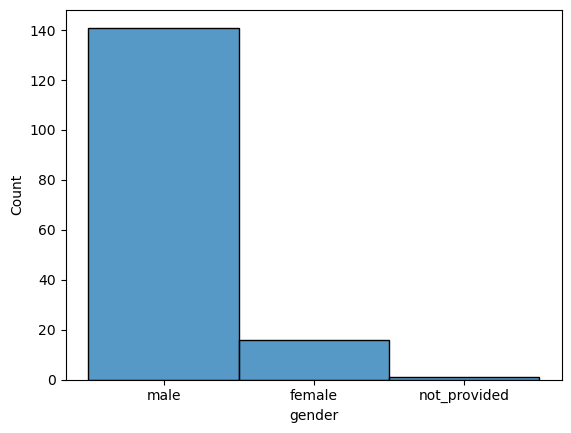

In [30]:
sns.histplot(df['gender']);

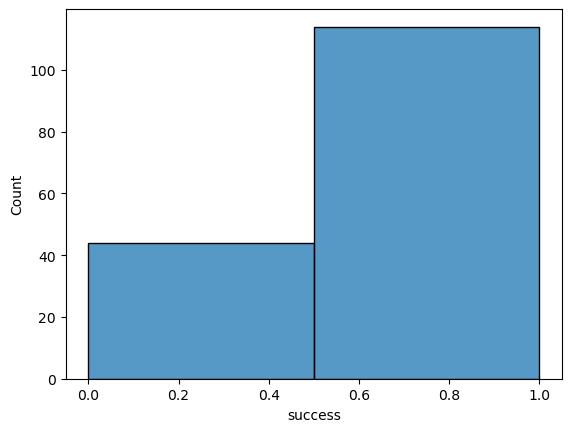

In [31]:
sns.histplot(df['success'], bins=2);

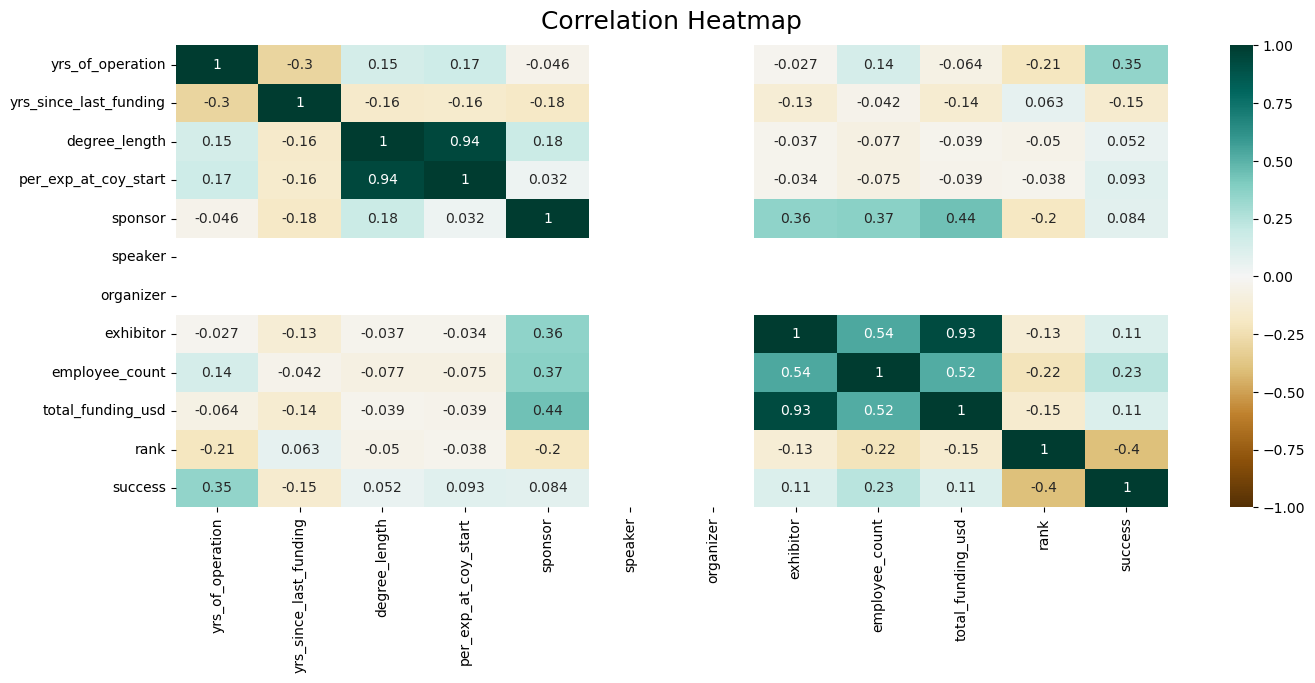

In [32]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

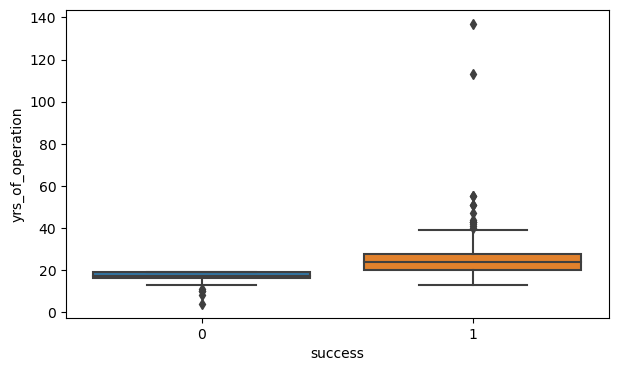

In [33]:
plt.figure(figsize=(7, 4))
sns.boxplot( x=df['success'], y=df['yrs_of_operation']);

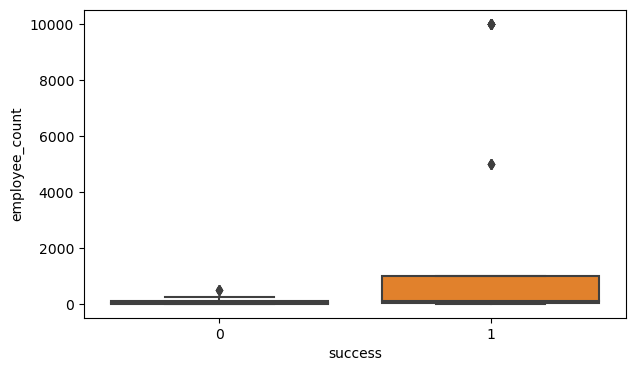

In [34]:
plt.figure(figsize=(7, 4))
sns.boxplot( x=df['success'], y=df['employee_count']);

In [35]:
# Split the dataset into Training, Validation and Test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [36]:
train, validate = train_test_split(train, test_size=0.2, random_state=42)

In [37]:
train.shape

(100, 28)

In [38]:
validate.shape

(26, 28)

In [39]:
test.shape

(32, 28)

In [40]:
# save the training dataset 
train.to_csv('D:\\OneDrive\\Documents\\PERSONAL\\PERSONAL DEVELOPMENT\\DATA SCIENCE\\'
    'Personal Project Portfolio\\PP00017_Prediction of the Success of Start-Ups Using Unbiased Classification ML Models'
    '\\artifacts\\data_transformation\\train_data.csv', index=False)

In [41]:
# save the validation dataset 
validate.to_csv('D:\\OneDrive\\Documents\\PERSONAL\\PERSONAL DEVELOPMENT\\DATA SCIENCE\\'
    'Personal Project Portfolio\\PP00017_Prediction of the Success of Start-Ups Using Unbiased Classification ML Models'
    '\\artifacts\\data_transformation\\validation_data.csv', index=False)

In [42]:
# save the test dataset 
test.to_csv('D:\\OneDrive\\Documents\\PERSONAL\\PERSONAL DEVELOPMENT\\DATA SCIENCE\\'
    'Personal Project Portfolio\\PP00017_Prediction of the Success of Start-Ups Using Unbiased Classification ML Models'
    '\\artifacts\\data_transformation\\test_data.csv', index=False)

# Column Transformation Pipelines

In [43]:
train = pd.read_csv('D:\\OneDrive\\Documents\\PERSONAL\\PERSONAL DEVELOPMENT\\DATA SCIENCE\\'
    'Personal Project Portfolio\\PP00017_Prediction of the Success of Start-Ups Using Unbiased Classification ML Models'
    '\\artifacts\\data_transformation\\train_data.csv')
train.head(2)

,yrs_of_operation,yrs_since_last_funding,degree_length,per_exp_at_coy_start,sponsor,speaker,organizer,exhibitor,employee_count,total_funding_usd,rank,uuid,name,type,roles,status,category_list,category_groups_list,primary_role,organization_description,gender,featured_job_title,people_description,institution_name,degree_type,subject,degree_is_completed,success
0,25,0,0,0,0,0,0,0,1,0.0,249637,55951d54-d738-7ebf-825d-4bb5f1daf829,CVP Management,organization,investor,operating,"Advertising,Enterprise,Information Technology,...","Advertising,Information Technology,Mobile,Othe...",investor,CVP Management is a venture capital firm speci...,male,Venture Partner,Chuck Stuckey is the retired Chairman of RSA S...,not known,not known,not known,False,1
1,35,0,4,15,0,0,0,0,1,0.0,315084,8284507e-1bed-4357-12ec-1e0dbf954fd7,Labrador Ventures,organization,"investor,company",operating,"Finance,Financial Exchanges,Venture Capital","Financial Services,Lending and Investments",investor,Labrador Ventures is a seed stage venture fund...,male,"Founder ,Managing Director & Partner","Larry Kubal is the Founder, Managing Director ...",Duke University,BA,"Psychology, English",True,1


In [44]:
# Create a list of feature categorisations
num_features = ['yrs_of_operation', 'yrs_since_last_funding', 'degree_length', 'per_exp_at_coy_start', 
                      'sponsor', 'speaker', 'organizer', 'exhibitor', 'employee_count', 'total_funding_usd', 'rank']

text_features_o =  'organization_description'

text_features_p = 'people_description'

cat_features = ['uuid', 'name', 'type', 'roles', 'status', 'category_list', 
                      'category_groups_list', 'primary_role', 'gender', 
                      'featured_job_title', 'institution_name', 'degree_type',
                      'subject', 'degree_is_completed']

In [45]:
# Define individual pipelines
num_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scalar', StandardScaler())  
    ]


)

text_pipeline = Pipeline(
    steps=[
        ('vectorizer', TfidfVectorizer(stop_words="english"))
       
    ]
)
cat_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='not known')),
        ('one_hot', OneHotEncoder(handle_unknown='ignore')),
        ('scalar', StandardScaler(with_mean=False))
    ]
)

In [46]:
# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
        transformers=[
            ("text_o", text_pipeline, text_features_o),
            ("text_p", text_pipeline, text_features_p),
            ("num", num_pipeline, num_features),
            ("cat", cat_pipeline, cat_features)
        ]
)


In [47]:

import os

def save_object(file_path, obj):
    try:
        dir_path = os.path.dirname(file_path)
        os.makedirs(dir_path, exist_ok=True)
        with open(file_path, 'wb') as file_obj:
            dill.dump(obj, file_obj)
    except:
        print("error")


In [48]:
save_object("D:\\OneDrive\\Documents\\PERSONAL\\PERSONAL DEVELOPMENT\\DATA SCIENCE\\Personal Project Portfolio\\PP00017_Prediction of the Success of Start-Ups Using Unbiased Classification ML Models\\artifacts\\data_transformation\\preprocessor.pkl", preprocessor)


In [49]:
# Spilt the train, validate and test data into features and labels before applying the preprocessor
X_train = train.drop('success', axis=1)
y_train = train['success']

X_val = validate.drop('success', axis=1)

y_val = validate['success']

X_test = test.drop('success', axis=1)

y_test = test['success']


In [50]:
# Fit and transform the training input features data
X_train = preprocessor.fit_transform(X_train)

# Transform the Validation input features data
X_val = preprocessor.transform(X_val)

# Transform the Test input features data set
X_test = preprocessor.transform(X_test)


In [53]:
# Combine the X and y of the train, validate and test dataset and save to complete the transformation

# Train 
y_train_df = y_train.to_frame()
y_train_df.reset_index(drop=True, inplace=True)

# Combine X_train and y_train_df
train_df = pd.concat([pd.DataFrame(X_train.todense()), y_train_df], axis=1)

# Save to CSV file
train_df.to_csv("D:\\OneDrive\\Documents\\PERSONAL\\PERSONAL DEVELOPMENT\\"
                "DATA SCIENCE\\Personal Project Portfolio\\PP00017_Prediction of the Success of Start-Ups Using Unbiased Classification ML Models"
                "\\artifacts\\data_transformation\\train_arr.csv", index=False)

# Validate

y_val_df = y_val.to_frame()
y_val_df.reset_index(drop=True, inplace=True)

# Combine X_train and y_train_df
val_df = pd.concat([pd.DataFrame(X_val.todense()), y_val_df], axis=1)

# Save to CSV file
val_df.to_csv("D:\\OneDrive\\Documents\\PERSONAL\\PERSONAL DEVELOPMENT\\"
                "DATA SCIENCE\\Personal Project Portfolio\\PP00017_Prediction of the Success of Start-Ups Using Unbiased Classification ML Models"
                "\\artifacts\\data_transformation\\val_arr.csv", index=False)


# Test

y_test_df = y_test.to_frame()
y_test_df.reset_index(drop=True, inplace=True)

# Combine X_train and y_train_df
test_df = pd.concat([pd.DataFrame(X_test.todense()), y_test_df], axis=1)

# Save to CSV file
test_df.to_csv("D:\\OneDrive\\Documents\\PERSONAL\\PERSONAL DEVELOPMENT\\"
                "DATA SCIENCE\\Personal Project Portfolio\\PP00017_Prediction of the Success of Start-Ups Using Unbiased Classification ML Models"
                "\\artifacts\\data_transformation\\test_arr.csv", index=False)